# Imports And Setup

In [ ]:
# 📦 Install all required packages for Pneumonia Detection Notebook
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install Pillow tqdm numpy matplotlib seaborn scikit-learn


In [6]:
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, ConcatDataset
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🚀 Using device: {device}')
if torch.cuda.is_available():
    print(f'   GPU: {torch.cuda.get_device_name(0)}')
    print(f'   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

🚀 Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


# Data Transformations

In [7]:
print("\n" + "="*80)
print("📸 SETTING UP DATA TRANSFORMATIONS")
print("="*80)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.4, scale=(0.02, 0.2)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("✓ Training augmentations: Resize, Crop, Flip, Rotation, Affine, ColorJitter, Grayscale, Erasing")
print("✓ Validation/Test: Resize, Normalize only")


📸 SETTING UP DATA TRANSFORMATIONS
✓ Training augmentations: Resize, Crop, Flip, Rotation, Affine, ColorJitter, Grayscale, Erasing
✓ Validation/Test: Resize, Normalize only


# Load and Inspect Data

In [8]:
print("\n" + "="*80)
print("📂 LOADING DATASET")
print("="*80)

data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

if not os.path.exists(data_dir):
    raise FileNotFoundError(f"❌ Dataset directory not found: {data_dir}")

# Load original folders
train_folder = datasets.ImageFolder(os.path.join(data_dir, 'train'))
val_folder = datasets.ImageFolder(os.path.join(data_dir, 'val')) if os.path.exists(os.path.join(data_dir, 'val')) else None
test_folder = datasets.ImageFolder(os.path.join(data_dir, 'test'))

print(f"✓ Dataset directory found: {data_dir}")
print(f"\nOriginal split:")
print(f"  📊 Train: {len(train_folder.samples)} images")
if val_folder:
    print(f"  📊 Val:   {len(val_folder.samples)} images")
print(f"  📊 Test:  {len(test_folder.samples)} images")

# Show class distribution
class_names = train_folder.classes
print(f"\n  Classes: {class_names}")


📂 LOADING DATASET
✓ Dataset directory found: /kaggle/input/chest-xray-pneumonia/chest_xray

Original split:
  📊 Train: 5216 images
  📊 Val:   16 images
  📊 Test:  624 images

  Classes: ['NORMAL', 'PNEUMONIA']


Since we have only 16 images for validation we will combine it with the training dataset and create our custom split 

# Create Custom 70/30 Split 

In [9]:
print("\n" + "="*80)
print("✂️  CREATING 70/30 TRAIN/VAL SPLIT")
print("="*80)

# Combine train + val
all_samples = list(train_folder.samples)
if val_folder is not None:
    all_samples += list(val_folder.samples)

total_size = len(all_samples)


# Create 70/30 split
train_frac = 0.70
train_size = int(train_frac * total_size)
val_size = total_size - train_size

rng = torch.Generator().manual_seed(42)
perm = torch.randperm(total_size, generator=rng).tolist()
train_idx = perm[:train_size]
val_idx = perm[train_size:]

print(f"\n✓ New split created:")
print(f"  📊 Train: {train_size} images ({train_size/total_size*100:.1f}%)")
print(f"  📊 Val:   {val_size} images ({val_size/total_size*100:.1f}%)")
print(f"  📊 Test:  {len(test_folder.samples)} images (kept separate)")


✂️  CREATING 70/30 TRAIN/VAL SPLIT

✓ New split created:
  📊 Train: 3662 images (70.0%)
  📊 Val:   1570 images (30.0%)
  📊 Test:  624 images (kept separate)


# Custom Dataset Class

In [10]:
print("\n" + "="*80)
print("🔧 CREATING CUSTOM DATASETS")
print("="*80)

class SamplesDataset(Dataset):
    """Custom dataset that loads images from a list of (path, label) samples"""
    def __init__(self, samples, indices, transform=None):
        self.samples = samples
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        path, label = self.samples[real_idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset = SamplesDataset(all_samples, train_idx, transform=data_transforms['train'])
val_dataset = SamplesDataset(all_samples, val_idx, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms['test'])

image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
dataset_sizes = {k: len(v) for k, v in image_datasets.items()}

print(f"✓ Datasets created successfully")
print(f"  Final sizes: {dataset_sizes}")


🔧 CREATING CUSTOM DATASETS
✓ Datasets created successfully
  Final sizes: {'train': 3662, 'val': 1570, 'test': 624}


# Class Weights And Balanced Sampling

In [11]:
print("\n" + "="*80)
print("⚖️  CALCULATING CLASS WEIGHTS FOR IMBALANCED DATA")
print("="*80)

# Calculate class distribution
all_labels = [label for _, label in all_samples]
class_counts = np.bincount(all_labels, minlength=len(class_names))
total = class_counts.sum()

print(f"\nClass distribution in train+val:")
for i, name in enumerate(class_names):
    print(f"  {name:12s}: {class_counts[i]:5d} images ({class_counts[i]/total*100:.1f}%)")

# Calculate inverse frequency weights
weights = total / (len(class_counts) * class_counts.astype(float))
class_weights = torch.FloatTensor(weights).to(device)

print(f"\nClass weights for loss function:")
for i, name in enumerate(class_names):
    print(f"  {name:12s}: {weights[i]:.3f}")

# Create balanced sampler for training
print(f"\n🎲 Creating WeightedRandomSampler for balanced training...")
train_labels_for_indices = [all_samples[i][1] for i in train_idx]
class_counts_train = np.bincount(train_labels_for_indices, minlength=len(class_names))
inv_class_weights = 1.0 / (class_counts_train + 1e-8)
sample_weights = [inv_class_weights[label] for label in train_labels_for_indices]

train_sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)
print("✓ Balanced sampler created - ensures equal class representation in each epoch")


⚖️  CALCULATING CLASS WEIGHTS FOR IMBALANCED DATA

Class distribution in train+val:
  NORMAL      :  1349 images (25.8%)
  PNEUMONIA   :  3883 images (74.2%)

Class weights for loss function:
  NORMAL      : 1.939
  PNEUMONIA   : 0.674

🎲 Creating WeightedRandomSampler for balanced training...
✓ Balanced sampler created - ensures equal class representation in each epoch


# Create Dataloaders

In [12]:
print("\n" + "="*80)
print("🔄 CREATING DATA LOADERS")
print("="*80)

batch_size = 32
num_workers = 4

dataloaders = {
    'train': DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler, 
        num_workers=num_workers, 
        drop_last=True
    ),
    'val': DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    ),
    'test': DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
}

print(f"✓ DataLoaders created")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(dataloaders['train'])}")
print(f"  Val batches:   {len(dataloaders['val'])}")
print(f"  Test batches:  {len(dataloaders['test'])}")


🔄 CREATING DATA LOADERS
✓ DataLoaders created
  Batch size: 32
  Train batches: 114
  Val batches:   50
  Test batches:  20


# Model Architecture

In [13]:
print("\n" + "="*80)
print("🏗️  BUILDING MODEL ARCHITECTURE")
print("="*80)

def create_model(model_name='resnet34', num_classes=2, freeze_layers=True, dropout_rate=0.5):
    """Create a ResNet model with custom classifier head"""
    
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    else:
        raise ValueError('Unsupported model')

    # Freeze early layers, unfreeze layer4 and fc for fine-tuning
    if freeze_layers:
        for name, param in model.named_parameters():
            if 'layer4' not in name and 'fc' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    # Custom classifier head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout_rate * 0.5),
        nn.Linear(256, num_classes)
    )
    
    return model.to(device)

model = create_model('resnet34', num_classes=len(class_names), freeze_layers=True, dropout_rate=0.5)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model: ResNet34")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters:    {total_params - trainable_params:,}")
print(f"  Dropout rate:         {0.5}")


🏗️  BUILDING MODEL ARCHITECTURE


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model: ResNet34
  Total parameters:     21,416,514
  Trainable parameters: 13,246,210
  Frozen parameters:    8,170,304
  Dropout rate:         0.5


# Loss, Optimizer, Scheduler

In [14]:
print("\n" + "="*80)
print("🎯 SETTING UP TRAINING CONFIGURATION")
print("="*80)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4, 
    weight_decay=0.01
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
    verbose=True, 
    min_lr=1e-7
)

print(f"✓ Loss function: CrossEntropyLoss with class weights and label smoothing (0.1)")
print(f"✓ Optimizer: AdamW (lr=1e-4, weight_decay=0.01)")
print(f"✓ Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")


🎯 SETTING UP TRAINING CONFIGURATION
✓ Loss function: CrossEntropyLoss with class weights and label smoothing (0.1)
✓ Optimizer: AdamW (lr=1e-4, weight_decay=0.01)
✓ Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training Function

In [15]:
print("\n" + "="*80)
print("🏋️  TRAINING FUNCTION READY")
print("="*80)

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, 
                num_epochs=25, patience=12):
    """
    Train the model with early stopping and EMA validation tracking
    """
    best_loss = float('inf')
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    val_loss_ema = None
    ema_alpha = 0.4

    for epoch in range(num_epochs):
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*80}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase:5s}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f"{phase.upper():5s} → Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} ({epoch_acc*100:.2f}%)")

            # Validation phase - update scheduler and check for best model
            if phase == 'val':
                # Exponential moving average for smoother tracking
                if val_loss_ema is None:
                    val_loss_ema = epoch_loss
                else:
                    val_loss_ema = ema_alpha * epoch_loss + (1 - ema_alpha) * val_loss_ema

                print(f"       EMA Val Loss: {val_loss_ema:.4f}")
                scheduler.step(val_loss_ema)

                # Save best model
                if val_loss_ema < best_loss - 1e-6:
                    best_loss = val_loss_ema
                    epochs_no_improve = 0
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': epoch_loss,
                        'val_acc': epoch_acc,
                        'history': history
                    }, 'best_pneumonia_model.pth')
                    print(f"       ✓ BEST MODEL SAVED (EMA loss improved to {best_loss:.4f})")
                else:
                    epochs_no_improve += 1
                    print(f"       ⏳ No improvement for {epochs_no_improve} epoch(s)")

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f"\n{'='*80}")
            print(f"⚠️  EARLY STOPPING triggered after epoch {epoch+1}")
            print(f"{'='*80}")
            break

    print(f"\n{'='*80}")
    print(f"✅ TRAINING COMPLETED")
    print(f"{'='*80}")
    print(f"Loading best model (EMA Val Loss: {best_loss:.4f})...")
    
    checkpoint = torch.load('best_pneumonia_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, history


🏋️  TRAINING FUNCTION READY


# Train The Model

In [16]:
print("\n" + "="*80)
print("🚀 STARTING TRAINING")
print("="*80)

model, history = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    dataloaders, 
    dataset_sizes, 
    num_epochs=50, 
    patience=12
)

print("\n✅ Training phase complete!")


🚀 STARTING TRAINING

Epoch 1/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


TRAIN → Loss: 0.3479 | Acc: 0.8239 (82.39%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


VAL   → Loss: 0.5906 | Acc: 0.7134 (71.34%)
       EMA Val Loss: 0.5906
       ✓ BEST MODEL SAVED (EMA loss improved to 0.5906)

Epoch 2/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.88it/s]


TRAIN → Loss: 0.2862 | Acc: 0.9052 (90.52%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


VAL   → Loss: 0.4719 | Acc: 0.8248 (82.48%)
       EMA Val Loss: 0.5431
       ✓ BEST MODEL SAVED (EMA loss improved to 0.5431)

Epoch 3/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]


TRAIN → Loss: 0.2779 | Acc: 0.9167 (91.67%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]


VAL   → Loss: 0.3512 | Acc: 0.9255 (92.55%)
       EMA Val Loss: 0.4663
       ✓ BEST MODEL SAVED (EMA loss improved to 0.4663)

Epoch 4/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]


TRAIN → Loss: 0.2684 | Acc: 0.9203 (92.03%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3968 | Acc: 0.8701 (87.01%)
       EMA Val Loss: 0.4385
       ✓ BEST MODEL SAVED (EMA loss improved to 0.4385)

Epoch 5/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]


TRAIN → Loss: 0.2623 | Acc: 0.9255 (92.55%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


VAL   → Loss: 0.4203 | Acc: 0.8650 (86.50%)
       EMA Val Loss: 0.4312
       ✓ BEST MODEL SAVED (EMA loss improved to 0.4312)

Epoch 6/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.99it/s]


TRAIN → Loss: 0.2603 | Acc: 0.9323 (93.23%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


VAL   → Loss: 0.3283 | Acc: 0.9484 (94.84%)
       EMA Val Loss: 0.3900
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3900)

Epoch 7/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.89it/s]


TRAIN → Loss: 0.2554 | Acc: 0.9301 (93.01%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


VAL   → Loss: 0.4727 | Acc: 0.8274 (82.74%)
       EMA Val Loss: 0.4231
       ⏳ No improvement for 1 epoch(s)

Epoch 8/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


TRAIN → Loss: 0.2455 | Acc: 0.9326 (93.26%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3459 | Acc: 0.9325 (93.25%)
       EMA Val Loss: 0.3922
       ⏳ No improvement for 2 epoch(s)

Epoch 9/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]


TRAIN → Loss: 0.2376 | Acc: 0.9495 (94.95%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3677 | Acc: 0.9102 (91.02%)
       EMA Val Loss: 0.3824
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3824)

Epoch 10/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.91it/s]


TRAIN → Loss: 0.2510 | Acc: 0.9328 (93.28%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3340 | Acc: 0.9389 (93.89%)
       EMA Val Loss: 0.3631
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3631)

Epoch 11/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.98it/s]


TRAIN → Loss: 0.2487 | Acc: 0.9416 (94.16%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


VAL   → Loss: 0.3749 | Acc: 0.9045 (90.45%)
       EMA Val Loss: 0.3678
       ⏳ No improvement for 1 epoch(s)

Epoch 12/50


train: 100%|██████████| 114/114 [00:37<00:00,  3.01it/s]


TRAIN → Loss: 0.2478 | Acc: 0.9361 (93.61%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3339 | Acc: 0.9395 (93.95%)
       EMA Val Loss: 0.3542
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3542)

Epoch 13/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]


TRAIN → Loss: 0.2392 | Acc: 0.9465 (94.65%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


VAL   → Loss: 0.3446 | Acc: 0.9338 (93.38%)
       EMA Val Loss: 0.3504
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3504)

Epoch 14/50


train: 100%|██████████| 114/114 [00:37<00:00,  3.01it/s]


TRAIN → Loss: 0.2356 | Acc: 0.9495 (94.95%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


VAL   → Loss: 0.5681 | Acc: 0.7841 (78.41%)
       EMA Val Loss: 0.4375
       ⏳ No improvement for 1 epoch(s)

Epoch 15/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]


TRAIN → Loss: 0.2382 | Acc: 0.9451 (94.51%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


VAL   → Loss: 0.3927 | Acc: 0.8847 (88.47%)
       EMA Val Loss: 0.4196
       ⏳ No improvement for 2 epoch(s)

Epoch 16/50


train: 100%|██████████| 114/114 [00:38<00:00,  3.00it/s]


TRAIN → Loss: 0.2339 | Acc: 0.9484 (94.84%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


VAL   → Loss: 0.3727 | Acc: 0.9115 (91.15%)
       EMA Val Loss: 0.4008
       ⏳ No improvement for 3 epoch(s)

Epoch 17/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]


TRAIN → Loss: 0.2286 | Acc: 0.9514 (95.14%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3367 | Acc: 0.9395 (93.95%)
       EMA Val Loss: 0.3752
       ⏳ No improvement for 4 epoch(s)

Epoch 18/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]


TRAIN → Loss: 0.2374 | Acc: 0.9476 (94.76%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3944 | Acc: 0.8955 (89.55%)
       EMA Val Loss: 0.3829
       ⏳ No improvement for 5 epoch(s)

Epoch 19/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


TRAIN → Loss: 0.2223 | Acc: 0.9563 (95.63%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


VAL   → Loss: 0.3761 | Acc: 0.9096 (90.96%)
       EMA Val Loss: 0.3802
       ⏳ No improvement for 6 epoch(s)

Epoch 20/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.97it/s]


TRAIN → Loss: 0.2307 | Acc: 0.9503 (95.03%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


VAL   → Loss: 0.3667 | Acc: 0.9025 (90.25%)
       EMA Val Loss: 0.3748
       ⏳ No improvement for 7 epoch(s)

Epoch 21/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]


TRAIN → Loss: 0.2323 | Acc: 0.9519 (95.19%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3600 | Acc: 0.9127 (91.27%)
       EMA Val Loss: 0.3689
       ⏳ No improvement for 8 epoch(s)

Epoch 22/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]


TRAIN → Loss: 0.2283 | Acc: 0.9541 (95.41%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


VAL   → Loss: 0.3659 | Acc: 0.9115 (91.15%)
       EMA Val Loss: 0.3677
       ⏳ No improvement for 9 epoch(s)

Epoch 23/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]


TRAIN → Loss: 0.2374 | Acc: 0.9500 (95.00%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


VAL   → Loss: 0.3388 | Acc: 0.9325 (93.25%)
       EMA Val Loss: 0.3561
       ⏳ No improvement for 10 epoch(s)

Epoch 24/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]


TRAIN → Loss: 0.2226 | Acc: 0.9585 (95.85%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


VAL   → Loss: 0.3582 | Acc: 0.9204 (92.04%)
       EMA Val Loss: 0.3570
       ⏳ No improvement for 11 epoch(s)

Epoch 25/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]


TRAIN → Loss: 0.2352 | Acc: 0.9525 (95.25%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


VAL   → Loss: 0.3203 | Acc: 0.9548 (95.48%)
       EMA Val Loss: 0.3423
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3423)

Epoch 26/50


train: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]


TRAIN → Loss: 0.2248 | Acc: 0.9560 (95.60%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


VAL   → Loss: 0.3257 | Acc: 0.9529 (95.29%)
       EMA Val Loss: 0.3357
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3357)

Epoch 27/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


TRAIN → Loss: 0.2291 | Acc: 0.9525 (95.25%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


VAL   → Loss: 0.4028 | Acc: 0.8809 (88.09%)
       EMA Val Loss: 0.3625
       ⏳ No improvement for 1 epoch(s)

Epoch 28/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.88it/s]


TRAIN → Loss: 0.2270 | Acc: 0.9566 (95.66%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


VAL   → Loss: 0.3345 | Acc: 0.9478 (94.78%)
       EMA Val Loss: 0.3513
       ⏳ No improvement for 2 epoch(s)

Epoch 29/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


TRAIN → Loss: 0.2278 | Acc: 0.9574 (95.74%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


VAL   → Loss: 0.3243 | Acc: 0.9535 (95.35%)
       EMA Val Loss: 0.3405
       ⏳ No improvement for 3 epoch(s)

Epoch 30/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


TRAIN → Loss: 0.2248 | Acc: 0.9601 (96.01%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3394 | Acc: 0.9369 (93.69%)
       EMA Val Loss: 0.3401
       ⏳ No improvement for 4 epoch(s)

Epoch 31/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.85it/s]


TRAIN → Loss: 0.2217 | Acc: 0.9569 (95.69%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


VAL   → Loss: 0.3190 | Acc: 0.9631 (96.31%)
       EMA Val Loss: 0.3316
       ✓ BEST MODEL SAVED (EMA loss improved to 0.3316)

Epoch 32/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.86it/s]


TRAIN → Loss: 0.2221 | Acc: 0.9599 (95.99%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


VAL   → Loss: 0.3541 | Acc: 0.9268 (92.68%)
       EMA Val Loss: 0.3406
       ⏳ No improvement for 1 epoch(s)

Epoch 33/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.89it/s]


TRAIN → Loss: 0.2222 | Acc: 0.9599 (95.99%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


VAL   → Loss: 0.3393 | Acc: 0.9503 (95.03%)
       EMA Val Loss: 0.3401
       ⏳ No improvement for 2 epoch(s)

Epoch 34/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.86it/s]


TRAIN → Loss: 0.2189 | Acc: 0.9577 (95.77%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


VAL   → Loss: 0.3366 | Acc: 0.9414 (94.14%)
       EMA Val Loss: 0.3387
       ⏳ No improvement for 3 epoch(s)

Epoch 35/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.87it/s]


TRAIN → Loss: 0.2326 | Acc: 0.9541 (95.41%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


VAL   → Loss: 0.3540 | Acc: 0.9191 (91.91%)
       EMA Val Loss: 0.3448
       ⏳ No improvement for 4 epoch(s)

Epoch 36/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.87it/s]


TRAIN → Loss: 0.2168 | Acc: 0.9640 (96.40%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


VAL   → Loss: 0.3822 | Acc: 0.9045 (90.45%)
       EMA Val Loss: 0.3598
       ⏳ No improvement for 5 epoch(s)

Epoch 37/50


train: 100%|██████████| 114/114 [00:40<00:00,  2.82it/s]


TRAIN → Loss: 0.2248 | Acc: 0.9593 (95.93%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


VAL   → Loss: 0.3601 | Acc: 0.9178 (91.78%)
       EMA Val Loss: 0.3599
       ⏳ No improvement for 6 epoch(s)

Epoch 38/50


train: 100%|██████████| 114/114 [00:40<00:00,  2.82it/s]


TRAIN → Loss: 0.2156 | Acc: 0.9634 (96.34%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


VAL   → Loss: 0.3612 | Acc: 0.9197 (91.97%)
       EMA Val Loss: 0.3604
       ⏳ No improvement for 7 epoch(s)

Epoch 39/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.86it/s]


TRAIN → Loss: 0.2168 | Acc: 0.9593 (95.93%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


VAL   → Loss: 0.3368 | Acc: 0.9459 (94.59%)
       EMA Val Loss: 0.3510
       ⏳ No improvement for 8 epoch(s)

Epoch 40/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.90it/s]


TRAIN → Loss: 0.2201 | Acc: 0.9610 (96.10%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


VAL   → Loss: 0.3605 | Acc: 0.9223 (92.23%)
       EMA Val Loss: 0.3548
       ⏳ No improvement for 9 epoch(s)

Epoch 41/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


TRAIN → Loss: 0.2146 | Acc: 0.9629 (96.29%)


val  : 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


VAL   → Loss: 0.3473 | Acc: 0.9306 (93.06%)
       EMA Val Loss: 0.3518
       ⏳ No improvement for 10 epoch(s)

Epoch 42/50


train: 100%|██████████| 114/114 [00:40<00:00,  2.83it/s]


TRAIN → Loss: 0.2119 | Acc: 0.9664 (96.64%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3502 | Acc: 0.9306 (93.06%)
       EMA Val Loss: 0.3512
       ⏳ No improvement for 11 epoch(s)

Epoch 43/50


train: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


TRAIN → Loss: 0.2165 | Acc: 0.9656 (96.56%)


val  : 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


VAL   → Loss: 0.3478 | Acc: 0.9312 (93.12%)
       EMA Val Loss: 0.3498
       ⏳ No improvement for 12 epoch(s)

⚠️  EARLY STOPPING triggered after epoch 43

✅ TRAINING COMPLETED
Loading best model (EMA Val Loss: 0.3316)...

✅ Training phase complete!


# Evaluation Function

In [17]:
print("\n" + "="*80)
print("📊 EVALUATION ON TEST SET")
print("="*80)

def evaluate_model(model, dataloader):
    """Evaluate model and return predictions and labels"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
            all_probs.extend(probs.cpu().numpy())
    
    return all_labels, all_preds, all_probs

test_labels, test_preds, test_probs = evaluate_model(model, dataloaders['test'])

print("\n" + "="*80)
print("📈 TEST SET RESULTS")
print("="*80)

# Calculate metrics
test_acc = np.mean(np.array(test_labels) == np.array(test_preds))
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

print(f"\nOverall Metrics:")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")

print("\n" + "-"*80)
print("Per-Class Classification Report:")
print("-"*80)
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))



📊 EVALUATION ON TEST SET


Evaluating: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


📈 TEST SET RESULTS

Overall Metrics:
  Accuracy:  0.9295 (92.95%)
  F1 Score:  0.9287
  Precision: 0.9305
  Recall:    0.9295

--------------------------------------------------------------------------------
Per-Class Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      NORMAL     0.9481    0.8590    0.9013       234
   PNEUMONIA     0.9199    0.9718    0.9451       390

    accuracy                         0.9295       624
   macro avg     0.9340    0.9154    0.9232       624
weighted avg     0.9305    0.9295    0.9287       624



# Confusion Matrix


🎨 CREATING CONFUSION MATRIX VISUALIZATION


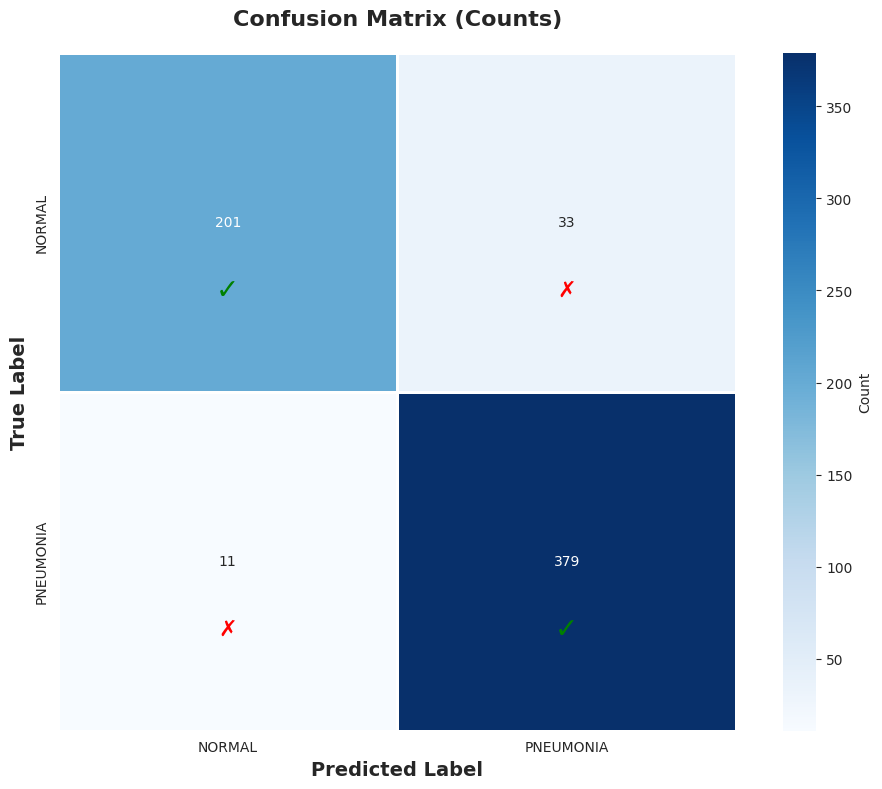

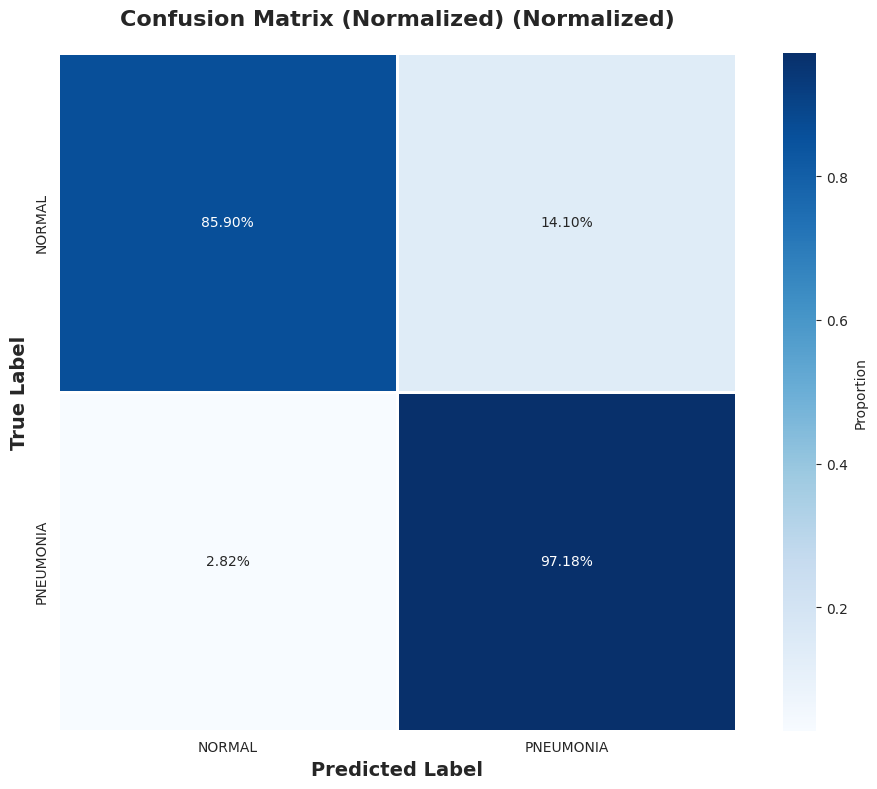

✓ Confusion matrices saved!


In [18]:
print("\n" + "="*80)
print("🎨 CREATING CONFUSION MATRIX VISUALIZATION")
print("="*80)

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix'):
    """
    Create a beautiful confusion matrix with seaborn
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
        title += ' (Normalized)'
    else:
        fmt = 'd'
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt=fmt, 
        cmap='Blues', 
        square=True,
        cbar_kws={'label': 'Count' if not normalize else 'Proportion'},
        xticklabels=classes,
        yticklabels=classes,
        linewidths=2,
        linecolor='white',
        ax=ax
    )
    
    # Styling
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Add accuracy text for each cell
    if not normalize:
        for i in range(len(classes)):
            for j in range(len(classes)):
                if i == j:
                    # Correct predictions - add checkmark
                    text = ax.text(j+0.5, i+0.7, '✓', ha='center', va='center',
                                 color='green', fontsize=20, fontweight='bold')
                else:
                    # Incorrect predictions - add X
                    if cm[i, j] > 0:
                        text = ax.text(j+0.5, i+0.7, '✗', ha='center', va='center',
                                     color='red', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    return fig, ax

# Plot both raw and normalized confusion matrices
fig1, ax1 = plot_confusion_matrix(test_labels, test_preds, class_names, 
                                   normalize=False, title='Confusion Matrix (Counts)')
plt.savefig('confusion_matrix_counts.png', dpi=300, bbox_inches='tight')
plt.show()

fig2, ax2 = plot_confusion_matrix(test_labels, test_preds, class_names, 
                                   normalize=True, title='Confusion Matrix (Normalized)')
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved!")


# History Plots


📉 PLOTTING TRAINING HISTORY


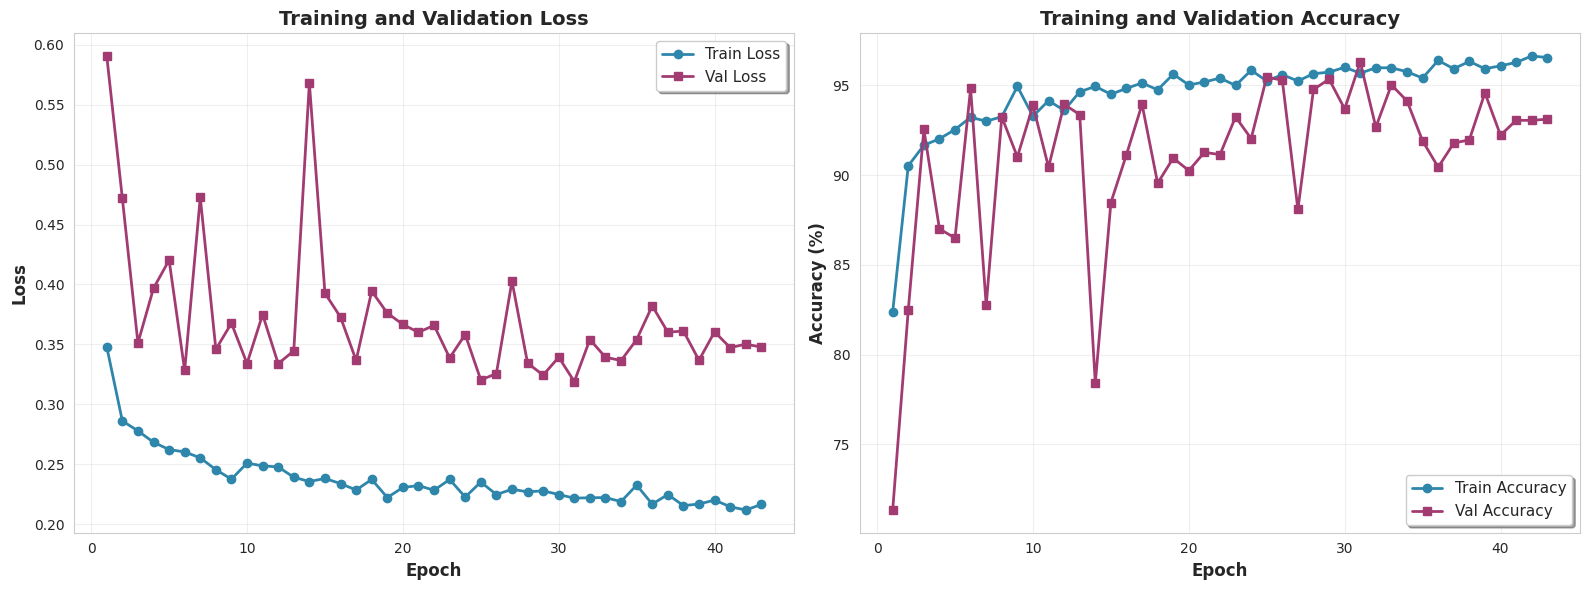


📊 Final Training Metrics:
  Train Loss: 0.2165
  Train Acc:  96.56%
  Val Loss:   0.3478
  Val Acc:    93.12%
✓ Training history plots saved!


In [19]:
print("\n" + "="*80)
print("📉 PLOTTING TRAINING HISTORY")
print("="*80)

def plot_training_history(history):
    """Create beautiful training history plots"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'o-', label='Train Loss', 
                linewidth=2, markersize=6, color='#2E86AB')
    axes[0].plot(epochs, history['val_loss'], 's-', label='Val Loss', 
                linewidth=2, markersize=6, color='#A23B72')
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11, frameon=True, shadow=True)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(epochs, [acc*100 for acc in history['train_acc']], 'o-', 
                label='Train Accuracy', linewidth=2, markersize=6, color='#2E86AB')
    axes[1].plot(epochs, [acc*100 for acc in history['val_acc']], 's-', 
                label='Val Accuracy', linewidth=2, markersize=6, color='#A23B72')
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11, frameon=True, shadow=True)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    print(f"\n📊 Final Training Metrics:")
    print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Train Acc:  {history['train_acc'][-1]*100:.2f}%")
    print(f"  Val Loss:   {history['val_loss'][-1]:.4f}")
    print(f"  Val Acc:    {history['val_acc'][-1]*100:.2f}%")

plot_training_history(history)

print("✓ Training history plots saved!")

# Summary

In [20]:
print("\n" + "="*80)
print("✅ PNEUMONIA DETECTION MODEL - COMPLETE SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"  Train:      {dataset_sizes['train']} images")
print(f"  Validation: {dataset_sizes['val']} images")
print(f"  Test:       {dataset_sizes['test']} images")

print(f"\n🏗️  Model:")
print(f"  Architecture: ResNet34")
print(f"  Trainable parameters: {trainable_params:,}")

print(f"\n🎯 Test Performance:")
print(f"  Accuracy:  {test_acc*100:.2f}%")
print(f"  F1 Score:  {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")

print(f"\n💾 Saved Files:")
print(f"  ✓ best_pneumonia_model.pth")
print(f"  ✓ confusion_matrix_counts.png")
print(f"  ✓ confusion_matrix_normalized.png")
print(f"  ✓ training_history.png")

print("\n" + "="*80)
print("🎉 ALL DONE! Your pneumonia detection model is ready to use!")
print("="*80)


✅ PNEUMONIA DETECTION MODEL - COMPLETE SUMMARY

📊 Dataset:
  Train:      3662 images
  Validation: 1570 images
  Test:       624 images

🏗️  Model:
  Architecture: ResNet34
  Trainable parameters: 13,246,210

🎯 Test Performance:
  Accuracy:  92.95%
  F1 Score:  0.9287
  Precision: 0.9305
  Recall:    0.9295

💾 Saved Files:
  ✓ best_pneumonia_model.pth
  ✓ confusion_matrix_counts.png
  ✓ confusion_matrix_normalized.png
  ✓ training_history.png

🎉 ALL DONE! Your pneumonia detection model is ready to use!
